In [8]:
#Enter your application ID here:
AppID = "application_1470921925184_8879"

# If there is firewall between notebook server and elasticsearch cluster, tunneling to one node inside the cluster
proxy_on = True
proxies = {
    'http': 'socks5://localhost:9997',
    'https': 'socks5://localhost:9997'
}

# Getting logs data from elasticsearch
elasticsearch_host = 'svr17.spo'
elasticsearch_port = 9200
log_indexname = 'yarntracking'
log_type = 'container'

### Import libary

In [9]:
# These are all the modules we'll be using later. Make sure you can import them
from __future__ import print_function
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import json
from six.moves.urllib.request import urlretrieve
debug = False

### Common Functions

In [10]:
import time, sys

# update_progress() : Displays or updates a console progress bar
## Accepts a float between 0 and 1. Any int will be converted to a float.
## A value under 0 represents a 'halt'.
## A value at 1 or bigger represents 100%
def update_progress(progress):
    barLength = 10 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    try: 
        sys.stdout.write(text)
        sys.stdout.flush()
    except ValueError as e:
        print(e)

### Pointing the script to the location that store the json logs

In [27]:
import requests
import requesocks
import win_inet_pton

def check_ESsocks(elasticsearch_host, elasticsearch_port, proxies):
    print ('(+) Sending request with requesocks...')
    EShostport = 'http://' + elasticsearch_host + ':' + str(elasticsearch_port)
    session = requesocks.session()
    session.proxies = proxies
    res = session.get(EShostport)
    print(res.text)
    return res

# make sure ES is up and running
try:
    if proxy_on == True:
        res = requests.get('http://%s:%d' % (elasticsearch_host, elasticsearch_port),proxies=proxies)
        #check_ESsocks(elasticsearch_host, elasticsearch_port, proxies)
    else: # no proxy
        res = requests.get('http://%s:%d' % (elasticsearch_host, elasticsearch_port))
    print(res.content)
except requests.exceptions.ConnectionError as e:
    print("Cannot connect to elasticsearch cluster because of %s" % e)
except requests.exceptions.ProxyError as e:
    print(e)
except requests.exceptions.HTTPError as e:
    print(e)
except requests.exceptions.Timeout as e:
    print(e)

InvalidSchema: Missing dependencies for SOCKS support.

In [23]:
#create a folder and put the json file to this
import os
import errno

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
cwd = os.getcwd()
AppIdPath = cwd + "/" + AppID
make_sure_path_exists(AppIdPath)

In [26]:
#connect to our cluster
from elasticsearch import Elasticsearch
from elasticsearch import RequestsHttpConnection
es_url = [{'host': elasticsearch_host, 'port': elasticsearch_port}]

class MyConnection(RequestsHttpConnection):
    def __init__(self, *args, **kwargs):
        proxies = kwargs.pop('proxies', {})
        super(MyConnection, self).__init__(*args, **kwargs)
        self.session.proxies = proxies

es = Elasticsearch(es_url, connection_class=MyConnection, proxies = proxies)

print(es.info())

ConnectionError: ConnectionError(Missing dependencies for SOCKS support.) caused by: InvalidSchema(Missing dependencies for SOCKS support.)

In [165]:
search_body = '{"stored_fields": ["_id"],"query":{"match":{"application_info.appId":"' + AppID + '"}}}'
search_result= es.search(index=log_indexname, body=search_body)

total_cons = search_result["hits"]["total"]
if total_cons >= 10: #default docs return
    search_body = '{"stored_fields": ["_id"],"size":' + str(total_cons) + ',"query":{"match":{"application_info.appId":"' + AppID + '"}}}'
    search_result= es.search(index=log_indexname, body=search_body)
    total_cons = search_result["hits"]["total"]
print('Total number of container found: %d' % total_cons)
doc_ids = []
for i in range(total_cons):
    doc_ids.insert(i,search_result["hits"]["hits"][i]["_id"])
    
if total_cons > 10:
    print("First 10 items:")
    print(doc_ids[:10])
else:
    print(doc_ids)

Total number of container found: 1238
First 10 items:
[u'container_e94_1470921925184_8879_01_000592', u'container_e94_1470921925184_8879_01_000596', u'container_e94_1470921925184_8879_01_000604', u'container_e94_1470921925184_8879_01_000608', u'container_e94_1470921925184_8879_01_000614', u'container_e94_1470921925184_8879_01_000617', u'container_e94_1470921925184_8879_01_000618', u'container_e94_1470921925184_8879_01_000624', u'container_e94_1470921925184_8879_01_000632', u'container_e94_1470921925184_8879_01_000635']


In [166]:
import json
# download all container file to one folder for local process
i = 0
for id in doc_ids:
    i += 1
    update_progress(float(i)/total_cons)
    try:
        doc = es.get(index=log_indexname, doc_type=log_type, id=id)
        source = doc["_source"]
        outputfile = AppIdPath + "/" + id + '.jsonprofile'
        with open(outputfile, 'w') as fp:
            json.dump(source, fp)
    except Error as e:
        print(e) 

Percent: [##########] 100% Done...


In [21]:
#Assume we collected the log for the app already
#1. Check if there is logs file in the folder
#2. Report how many container we have, how many container we lost the information, verify if the container we lose infor
#   is not important
#3. Work like before

### Load the json to the tabular

In [167]:
import pandas as pd #this is how I usually import pandas

def load_application(folder):
  """Load the container data for each application."""
  container_index = 0
  container_name_list = []
  container_starttime_list = []
  container_endtime_list = []
  container_type_list = []
  container_task_list = []
  container_node_list = []
  container_node_mem_total_list = []
  container_node_CPU_total_list = []
  container_node_mem_rsrv_list = []
  container_node_CPU_rsrv_list = []
  container_mem_assigned_list = []
  container_CPU_assigned_list = []
  appId_list = [] #this one should be call appId
  appname_list = []
  appowner_list = []
  application_starttime = 100000000000000 # really big number
  application_endtime = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        container_starttime = data["container_starttime"]
        if container_starttime < application_starttime:
          application_starttime = container_starttime        
        container_endtime = data["container_endtime"]
        if container_endtime > application_endtime:
          application_endtime = container_endtime
        """gather info for container"""
        container_type = data["application_info"]["appType"] #First task only
        appId = data["application_info"]["appId"]
        appname = data["application_info"]["appName"]
        appowner = data["application_info"]["appOwner"]
        if not data["nodeInfo"]:
            container_node = "null"
            container_node_mem_total = 0
            container_node_CPU_total = 0
            container_node_mem_rsrv = 0
            container_node_CPU_rsrv = 0
            container_mem_assigned = 0
            container_CPU_assigned = 0
        else:
            container_node = data["nodeInfo"]["id"]
            container_node_mem_total = data["nodeInfo"]["totalNodePhyMem"]
            container_node_CPU_total = data["nodeInfo"]["totalNodePhyCore"]
            container_node_mem_rsrv = data["nodeInfo"]["totalPmemAllocatedContainersMB"] * 1024
            container_node_CPU_rsrv = data["nodeInfo"]["totalVCoresAllocatedContainers"]
            container_mem_assigned = data["MemoryAssignedMB"] * 1024
            container_CPU_assigned = data["VCoresAssigned"]
        if not data["container_tasks"]:
            container_task = "null"
        else:
            container_task = data["container_tasks"][0]["task_type"]
        """make list to create dataframe"""
        container_name_list.insert(container_index,container_name)
        container_starttime_list.insert(container_index,container_starttime)
        container_endtime_list.insert(container_index,container_endtime)
        container_type_list.insert(container_index,container_type)
        container_task_list.insert(container_index,container_task)
        container_node_list.insert(container_index,container_node)
        container_node_mem_total_list.insert(container_index,container_node_mem_total)
        container_node_CPU_total_list.insert(container_index,container_node_CPU_total)
        container_node_mem_rsrv_list.insert(container_index,container_node_mem_rsrv)
        container_node_CPU_rsrv_list.insert(container_index,container_node_CPU_rsrv)
        container_mem_assigned_list.insert(container_index,container_mem_assigned)
        container_CPU_assigned_list.insert(container_index,container_CPU_assigned)
        appId_list.insert(container_index,appId)
        appname_list.insert(container_index,appname)
        appowner_list.insert(container_index,appowner)
      #if not container_name:
      #  raise Exception('Unexpected container name')
      #if container_starttime == 0:
      #  raise Exception('Unexpected container start time')
      #if container_endtime == 0:
      #  raise Exception('Unexpected container end time')
      container_index += 1
    except IOError as e:
      print('Could not read:', container_file, ':', e)
    except ValueError as e:
      print('Wrong format. Could not read:', container_file, ':', e)
  DataSet = list(zip(container_starttime_list,container_endtime_list,
                     container_type_list,container_task_list,container_node_list,container_node_mem_total_list,
                     container_node_CPU_total_list,container_node_mem_rsrv_list,container_node_CPU_rsrv_list,
                     container_mem_assigned_list, container_CPU_assigned_list, appId_list, appname_list, appowner_list))
  columns=[ 'start', 'end', 'type', 'task', 'node','n_mem','n_CPU',
                                    'mem_rsrv','CPU_rsrv','mem','CPU','app','appname', 'appowner']
  DataFrame = pd.DataFrame(data = DataSet, index=container_name_list,
                           columns=columns)
  return DataFrame, application_starttime, application_endtime

In [168]:
application_dataframe, application_starttime, application_endtime = load_application(AppIdPath)
print('Snapshot start time: %s' % application_starttime)
print('Snapshot end time: %s' % application_endtime)
application_duration = application_endtime - application_starttime
print('Snapshot duration: %s ms (or ~%s s or ~%s m)' % (application_duration,application_duration/1000,application_duration/60000))
application_dataframe.head(n=5)

Snapshot start time: 1472099377414
Snapshot end time: 1472100008638
Snapshot duration: 631224 ms (or ~631 s or ~10 m)


start            end  \
container_e94_1470921925184_8879_01_000001  1472099377414  1472100008638   
container_e94_1470921925184_8879_01_000002  1472099384663  1472099406701   
container_e94_1470921925184_8879_01_000003  1472099384664  1472099406910   
container_e94_1470921925184_8879_01_000004  1472099384664  1472099406910   
container_e94_1470921925184_8879_01_000005  1472099384665  1472099407054   

                                                 type task  \
container_e94_1470921925184_8879_01_000001  MAPREDUCE   AM   
container_e94_1470921925184_8879_01_000002  MAPREDUCE  MAP   
container_e94_1470921925184_8879_01_000003  MAPREDUCE  MAP   
container_e94_1470921925184_8879_01_000004  MAPREDUCE  MAP   
container_e94_1470921925184_8879_01_000005  MAPREDUCE  MAP   

                                                                                         node  \
container_e94_1470921925184_8879_01_000001  datanode002.current.rec.mapreduce.m1.p.fti.net...   
container_e94_1470921925184_8879_01_000002  datanode006.current.rec.mapreduce.m1.p.fti.net...   
container_e94_1470921925184_8879_01_000003  datanode006.current.rec.mapreduce.m1.p.fti.net...   
container_e94_1470921925184_8879_01_000004  datanode006.current.rec.mapreduce.m1.p.fti.net...   
container_e94_1470921925184_8879_01_000005  datanode006.current.rec.mapreduce.m1.p.fti.net...   

                                               n_mem  n_CPU  mem_rsrv  \
container_e94_1470921925184_8879_01_000001  66058808     24  56623104   
container_e94_1470921925184_8879_01_000002  66058808     24  56623104   
container_e94_1470921925184_8879_01_000003  66058808     24  56623104   
container_e94_1470921925184_8879_01_000004  66058808     24  56623104   
container_e94_1470921925184_8879_01_000005  66058808     24  56623104   

                                            CPU_rsrv      mem  CPU  \
container_e94_1470921925184_8879_01_000001        24  2097152    1   
container_e94_1470921925184_8879_01_000002        24  2097152    1   
container_e94_1470921925184_8879_01_000003        24  2097152    1   
container_e94_1470921925184_8879_01_000004        24  2097152    1   
container_e94_1470921925184_8879_01_000005        24  2097152    1   

                                                                       app  \
container_e94_1470921925184_8879_01_000001  application_1470921925184_8879   
container_e94_1470921925184_8879_01_000002  application_1470921925184_8879   
container_e94_1470921925184_8879_01_000003  application_1470921925184_8879   
container_e94_1470921925184_8879_01_000004  application_1470921925184_8879   
container_e94_1470921925184_8879_01_000005  application_1470921925184_8879   

                                                        appname       appowner  
container_e94_1470921925184_8879_01_000001  ute:catalogue-noepg  profiling-ute  
container_e94_1470921925184_8879_01_000002  ute:catalogue-noepg  profiling-ute  
container_e94_1470921925184_8879_01_000003  ute:catalogue-noepg  profiling-ute  
container_e94_1470921925184_8879_01_000004  ute:catalogue-noepg  profiling-ute  
container_e94_1470921925184_8879_01_000005  ute:catalogue-noepg  profiling-ute

In [169]:
ApplicationDataFrame = application_dataframe.sort_values(by="node")

print('Distribution of containers on nodes:')
ApplicationDataFrame.groupby('node').count().app

Distribution of containers on nodes:


node
datanode001.current.rec.mapreduce.m1.p.fti.net:45454     98
datanode002.current.rec.mapreduce.m1.p.fti.net:45454    152
datanode003.current.rec.mapreduce.m1.p.fti.net:45454    335
datanode005.current.rec.mapreduce.m1.p.fti.net:45454    101
datanode006.current.rec.mapreduce.m1.p.fti.net:45454    552
Name: app, dtype: int64

### Load the CPU usage to the tabular

In [170]:
def load_application_cpu_profile(folder):
  """Load the container data for each application."""
  record_index_list = []
  container_name_list = []
  capture_time_list = []
  container_load_list = []
  cpu_us_list = []
  cpu_sys_list = []
  cpu_id_list = []
  fail_count = 0
  record_index = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        if not data["cpu_usage"]:
          print('No cpu usage infomation for container %s, ignore it' % container_name)
          fail_count = fail_count + 1
        else:
          for record in data["cpu_usage"]:
            container_capture_time = record["capture_time"]
            container_load = record["container_load"] / 100
            cpu_us = record["cpu_us"]
            cpu_sys = record["cpu_sy"]
            cpu_id = record["cpu_id"]
            '''make list to create dataframe'''
            record_index_list.insert(record_index,record_index)
            container_name_list.insert(record_index,container_name)
            capture_time_list.insert(record_index,container_capture_time)
            container_load_list.insert(record_index,container_load)
            cpu_us_list.insert(record_index,cpu_us)
            cpu_sys_list.insert(record_index,cpu_sys)
            cpu_id_list.insert(record_index,cpu_id)
            record_index += 1
      if not container_name:
        raise Exception('Unexpected container name')
    except IOError as e:
      print('Could not read:', container_file, ':', e)
    except ValueError as e:
      print('Wrong format. Could not read:', container_file, ':', e)
  DataSet = list(zip(capture_time_list,container_name_list,container_load_list,cpu_us_list,cpu_sys_list,cpu_id_list))
  columns=[ 'timestamp','name','cpu_load', 'cpu_us', 'cpu_sys', 'cpu_id']
  DataFrame = pd.DataFrame(data = DataSet, index=record_index_list,columns=columns)
  return DataFrame, fail_count

app_cpu_profile, app_fail_count = load_application_cpu_profile(AppIdPath)
print("There are %d containers having no information on the resource usage, we omit them" % app_fail_count)
app_cpu_profile.head(n=5)
# Should list the container that does not have record

No cpu usage infomation for container container_e94_1470921925184_8879_01_001237, ignore it
No cpu usage infomation for container container_e94_1470921925184_8879_01_001238, ignore it
There are 2 containers having no information on the resource usage, we omit them


timestamp                                        name  cpu_load  cpu_us  \
0  1472099380  container_e94_1470921925184_8879_01_000001     1.897     6.1   
1  1472099381  container_e94_1470921925184_8879_01_000001     2.746    14.1   
2  1472099382  container_e94_1470921925184_8879_01_000001     4.046    20.5   
3  1472099383  container_e94_1470921925184_8879_01_000001     6.174    29.9   
4  1472099384  container_e94_1470921925184_8879_01_000001     0.999    13.1   

   cpu_sys  cpu_id  
0      1.1    92.5  
1      9.0    76.9  
2      9.0    70.4  
3      9.2    60.8  
4      9.5    77.4

In [171]:
def get_cpu_actual_use(container_name, snapshot_dataframe, snapshot_cpu_profile):
    container_starttime = snapshot_dataframe.loc[container_name,'start']
    container_endtime = snapshot_dataframe.loc[container_name,'end']
    rescaled_container_starttime = container_starttime / 1000
    rescaled_container_endtime = container_endtime / 1000
    duration = rescaled_container_endtime - rescaled_container_starttime
    container_index = np.linspace(rescaled_container_starttime, rescaled_container_endtime -1,duration)
    data = np.linspace(0,0,duration)
    container_data2 = pd.Series(data,index=pd.to_datetime(container_index,unit='s'))

    cpu_container_filtered = snapshot_cpu_profile[(snapshot_cpu_profile.name == container_name)]
    index = cpu_container_filtered.timestamp.tolist()
    cpu_load = cpu_container_filtered.cpu_load.tolist()
    container_data1 = pd.Series(cpu_load,index=pd.to_datetime(index,unit='s'))
    container_data3 = container_data1 + container_data2
    container_data4 = container_data3.interpolate(method='time')
    for index in container_data4.index:
        try:
            if pd.isnull(container_data4[index]):
                container_data4[index] = 0
        except ValueError as e:
            print("index: %s of %s with length %d" % (index, container_name, len(container_data4[index])))
            #print("data: %s" % container_data4[index])
            #raise Exception("Too many item in one index", e)
    if len(container_data4) > len(container_data2):
        a = set(container_data4.index.tolist()) - set(container_data2.index.tolist())
        if debug == True:
            print(a)
        #raise Exception('Return length mismatch')
    
    return container_data4

### Load the Memory usage to the tabular

In [172]:
def load_application_mem_profile(folder):
  """Load the container data for each application."""
  record_index_list = []
  container_name_list = []
  capture_time_list = []
  container_mem_virt_list = []
  container_mem_res_list = []
  container_mem_shr_list = []
  used_pmem_list = [] #system info
  swap_cached_list = [] # system info
  fail_count = 0
  record_index = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        if not data["memory_usage"]:
          print('No memory usage infomation for container %s, ignore it' % container_name)
          fail_count = fail_count + 1
        else:
          for record in data["memory_usage"]:
            container_capture_time = record["capture_time"]
            container_mem_virt = record["virt"]
            container_mem_res = record["res"]
            container_mem_shr = record["shr"]
            used_pmem = record["used_pmem"]
            swap_cached = record["swap_cached"]
            '''make list to create dataframe'''
            record_index_list.insert(record_index,record_index)
            container_name_list.insert(record_index,container_name)
            capture_time_list.insert(record_index,container_capture_time)
            container_mem_virt_list.insert(record_index,container_mem_virt)
            container_mem_res_list.insert(record_index,container_mem_res)
            container_mem_shr_list.insert(record_index,container_mem_shr)
            used_pmem_list.insert(record_index,used_pmem)
            swap_cached_list.insert(record_index,swap_cached)
            record_index += 1
      if not container_name:
        raise Exception('Unexpected container name')
    except IOError as e:
      print('Could not read:', container_file, ':', e)
    except ValueError as e:
      print('Wrong format. Could not read:', container_file, ':', e)
  DataSet = list(zip(capture_time_list,container_name_list,container_mem_virt_list,
                     container_mem_res_list,container_mem_shr_list,used_pmem_list,swap_cached_list))
  columns=[ 'timestamp','name','virt', 'res', 'shr', 'used_pmem','swap_cached']
  DataFrame = pd.DataFrame(data = DataSet, index=record_index_list,columns=columns)
  return DataFrame, fail_count

app_mem_profile, app_fail_count = load_application_mem_profile(AppIdPath)
print('We found %d containers having no information on the memory usage' % app_fail_count)
app_mem_profile.head(n=5)

No memory usage infomation for container container_e94_1470921925184_8879_01_001237, ignore it
No memory usage infomation for container container_e94_1470921925184_8879_01_001238, ignore it
We found 2 containers having no information on the memory usage


timestamp                                        name        virt  \
0  1472099380  container_e94_1470921925184_8879_01_000001  3627024384   
1  1472099381  container_e94_1470921925184_8879_01_000001  3651141632   
2  1472099382  container_e94_1470921925184_8879_01_000001  3674210304   
3  1472099383  container_e94_1470921925184_8879_01_000001  3735027712   
4  1472099384  container_e94_1470921925184_8879_01_000001  3728736256   

         res       shr    used_pmem  swap_cached  
0  262144000  23068672  62265921536  46980251648  
1  379584512  23068672  62375829504  46979178496  
2  483393536  24117248  62480371712  46980247552  
3  531628032  24117248  62530977792  46980337664  
4  528482304  24117248  62603624448  46981582848

In [173]:
def get_mem_actual_use(container_name, snapshot_dataframe, snapshot_mem_profile):
    container_starttime = snapshot_dataframe.loc[container_name,'start']
    container_endtime = snapshot_dataframe.loc[container_name,'end']
    rescaled_container_starttime = container_starttime / 1000
    rescaled_container_endtime = container_endtime / 1000
    duration = rescaled_container_endtime - rescaled_container_starttime
    container_index = np.linspace(rescaled_container_starttime, rescaled_container_endtime -1,duration)
    data = np.linspace(0,0,duration)
    container_data2 = pd.Series(data,index=pd.to_datetime(container_index,unit='s'))

    mem_container_filtered = snapshot_mem_profile[(snapshot_mem_profile.name == container_name)]
    index = mem_container_filtered.timestamp.tolist()
    # get resident memory
    mem = mem_container_filtered.res.tolist()
    # get share memory
    #mem = mem_container_filtered.shr.tolist()
    # get virt memory
    #mem = mem_container_filtered.virt.tolist()
    container_data1 = pd.Series(mem,index=pd.to_datetime(index,unit='s'))
    container_data3 = container_data1 + container_data2
    container_data4 = container_data3.interpolate(method='time')
    for index in container_data4.index:
        try:
            if pd.isnull(container_data4[index]):
                container_data4[index] = 0
        except ValueError as e:
            print("index: %s of %s with length %d" % (index, container_name, len(container_data4[index])))
            #print("data: %s" % container_data4[index])
            #raise Exception("Too many item in one index", e)
    if len(container_data4) > len(container_data2):
        a = set(container_data4.index.tolist()) - set(container_data2.index.tolist())
        if debug == True:
            print(a)
        #raise Exception('Return length mismatch')
    
    return container_data4

### Analysing the data

In [25]:
# Display resource usage of one container
con_st = 
con_ed =
con_du = con_ed - con_st

# create vector to display
node_cpu_us =  # cpu used in user space
node_cpu_si =  # cpu used in kernel space
node_cpu_id =  # cpu idle
node_cpu_st =  # cpu steal (if run in virtual environment)


node_memfree
node_memusage
node_memswap

con_memusage
con_memresv
con_memswap


In [26]:
# Display resource usage of all containers on one node

In [178]:
%matplotlib inline
AppDFSorted = application_dataframe.sort_values(by="node")
AppDFFiltered = AppDFSorted

# Filter by node
AppDFFiltered = AppDFSorted[(AppDFSorted.node == "datanode005.current.rec.mapreduce.m1.p.fti.net:45454")]

# Display resource usage of all containers of one application in one single view
'''FOR CPU'''
AppDFFiltered_group_node = AppDFFiltered.groupby("node")
total_phy_CPU = AppDFFiltered_group_node.n_CPU.mean().sum() #assume capacity has no change
total_rsrv_CPU = AppDFFiltered_group_node.CPU_rsrv.mean().sum() #assume capacity has no change
print('Total physical cores in these nodes: %s cores' % total_phy_CPU)
print('Total virtual cores reserved for YARN in these nodes: %s cores' % total_rsrv_CPU)

# create vector zero
app_starttime = AppDFFiltered.start.min()    # overwrite the starting point after filter
app_endtime =  AppDFFiltered.end.max()     # overwrite the end point after filter
rescaled_app_starttime = app_starttime / 1000
rescaled_app_endtime = app_endtime / 1000
rescaled_app_duration = rescaled_app_endtime - rescaled_app_starttime
time = np.linspace(rescaled_app_starttime, rescaled_app_endtime-1,rescaled_app_duration)
zero_vector = pd.Series(np.linspace(0, 0,rescaled_app_duration), index=time)
base_vector_cpu_resv = zero_vector
base_vector_cpu_actl = zero_vector
base_vector_mem_resv = zero_vector
base_vector_mem_actl = zero_vector

phy_CPU = np.linspace(total_phy_CPU,total_phy_CPU,rescaled_app_duration)
rsrv_CPU = np.linspace(total_rsrv_CPU,total_rsrv_CPU,rescaled_app_duration)
phy_CPU = pd.Series(phy_CPU,index=time)
rsrv_CPU = pd.Series(rsrv_CPU,index=time)

'''FOR MEMORY'''
total_phy_mem = AppDFFiltered_group_node.n_mem.mean().sum() #assume capacity has no change
total_rsrv_mem = AppDFFiltered_group_node.mem_rsrv.mean().sum() #assume capacity has no change
# convert from KB to GB
total_phy_mem = float(total_phy_mem) / (1024*1024)
total_rsrv_mem = float(total_rsrv_mem) / (1024*1024)
print('Total physical memory in these nodes: %s GBs' % total_phy_mem)
print('Total memory reserved for YARN in these nodes: %s GBs' % total_rsrv_mem)

phy_mem = np.linspace(total_phy_mem,total_phy_mem,rescaled_app_duration)
rsrv_mem = np.linspace(total_rsrv_mem,total_rsrv_mem,rescaled_app_duration)
phy_mem = pd.Series(phy_mem,index=time)
rsrv_mem = pd.Series(rsrv_mem,index=time)

'''FOR BOTH'''
i = 0
total_cons = len(AppDFFiltered.index)
for index in AppDFFiltered.index:
    i = i + 1
    update_progress(float(i)/total_cons)
    # get CPU allocated for that container
    container_starttime = AppDFFiltered.loc[index,'start']
    container_endtime = AppDFFiltered.loc[index,'end']
    rescaled_container_starttime = int(container_starttime) / 1000
    rescaled_container_endtime = int(container_endtime) / 1000
    container_duration = rescaled_container_endtime - rescaled_container_starttime
    ###### CPU Reservation
    container_cpu_value = np.linspace(AppDFFiltered.loc[index,'CPU'],
                                    AppDFFiltered.loc[index,'CPU'],
                                    container_duration)
    container_time_index = np.linspace(rescaled_container_starttime,
                                           rescaled_container_endtime-1,
                                           container_duration)
    container_cpu_resv_data = pd.Series(container_cpu_value, index=container_time_index)
    # checking if all points in container data belongs to the snapshot timeframe
    #check = set(container_time_index) - set(time)
    #if len(check): #not empty
    #  print(index)
    #  raise Exception("Error, data point's mismatch")
    ###### actual CPU used '''
    actual_cpu_use = get_cpu_actual_use(index,application_dataframe, app_cpu_profile)
    actual_cpu_use = actual_cpu_use.tolist()
    '''because the return may have lengh longer, we generate the container_time_index again'''
    container_cpu_time_index = np.linspace(rescaled_container_starttime,
                                               rescaled_container_starttime+(len(actual_cpu_use)-1),
                                               len(actual_cpu_use))
    container_cpu_actl_data = pd.Series(actual_cpu_use, index=container_cpu_time_index)
    # checking if all points in container data belongs to the snapshot timeframe
    check = set(container_cpu_time_index) - set(time)
    if len(check): #not empty
        print(index)
    #  raise Exception("Error, data point's mismatch")
    ####### memory reservation
    mem = float(AppDFFiltered.loc[index,'mem']) / (1024*1024)
    container_mem_value = np.linspace(mem,mem,container_duration)
    container_mem_resv_data = pd.Series(container_mem_value, index=container_time_index)
    ####### actual memory
    actual_mem_use = get_mem_actual_use(index,application_dataframe, app_mem_profile)
    actual_mem_use = actual_mem_use.tolist()
    actual_mem_use = [x / (1024*1024*1024) for x in actual_mem_use]
    '''because the return may have lengh longer, we generate the container_time_index again'''
    container_mem_time_index = np.linspace(rescaled_container_starttime,
                                         rescaled_container_starttime+len(actual_mem_use)-1,
                                         len(actual_mem_use))
    container_mem_actl_data = pd.Series(actual_mem_use, index=container_mem_time_index)
    # checking if all points in container data belongs to the snapshot timeframe
    #check = set(container_mem_time_index) - set(time)
    #if len(check): #not empty
    #  raise Exception("Error, data point's mismatch")        
    # matching the container data with the length of the snapshot
    container_cpu_resv_data = container_cpu_resv_data + zero_vector
    container_cpu_resv_data = container_cpu_resv_data.fillna(0)
    container_cpu_actl_data = container_cpu_actl_data + zero_vector
    container_cpu_actl_data = container_cpu_actl_data.fillna(0)
    container_mem_resv_data = container_mem_resv_data + zero_vector
    container_mem_resv_data = container_mem_resv_data.fillna(0)
    container_mem_actl_data = container_mem_actl_data + zero_vector
    container_mem_actl_data = container_mem_actl_data.fillna(0)
    # create drawing vector based on base_vector
    container_cpu_resv_data = container_cpu_resv_data + base_vector_cpu_resv #add up new data
    base_vector_cpu_resv = container_cpu_resv_data # update base_vector for next iteration
    container_cpu_actl_data = container_cpu_actl_data + base_vector_cpu_actl #add up new data
    base_vector_cpu_actl = container_cpu_actl_data # update base_vector for next iteration
    container_mem_resv_data = container_mem_resv_data + base_vector_mem_resv #add up new data
    base_vector_mem_resv = container_mem_resv_data # update base_vector for next iteration
    container_mem_actl_data = container_mem_actl_data + base_vector_mem_actl #add up new data
    base_vector_mem_actl = container_mem_actl_data # update base_vector for next iteration
resv_cpu = base_vector_cpu_resv
actl_cpu = base_vector_cpu_actl
resv_mem = base_vector_mem_resv
actl_mem = base_vector_mem_actl

Total physical cores in these nodes: 24 cores
Total virtual cores reserved for YARN in these nodes: 24 cores
Total physical memory in these nodes: 62.998588562 GBs
Total memory reserved for YARN in these nodes: 54.0 GBs
Percent: [##########] 100% Done...


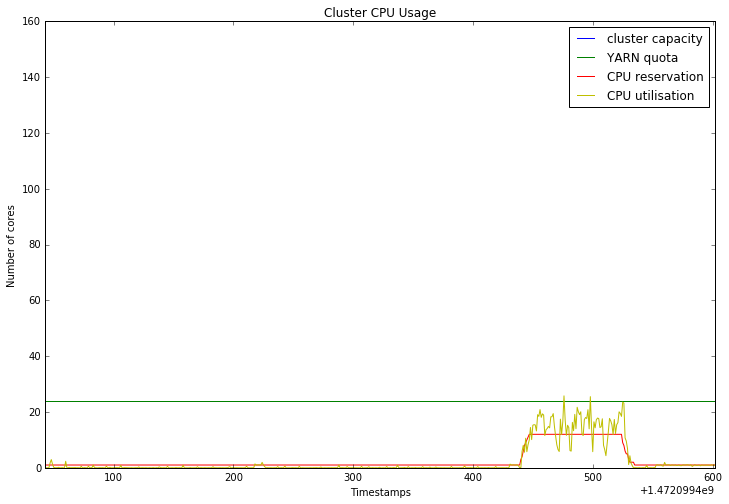

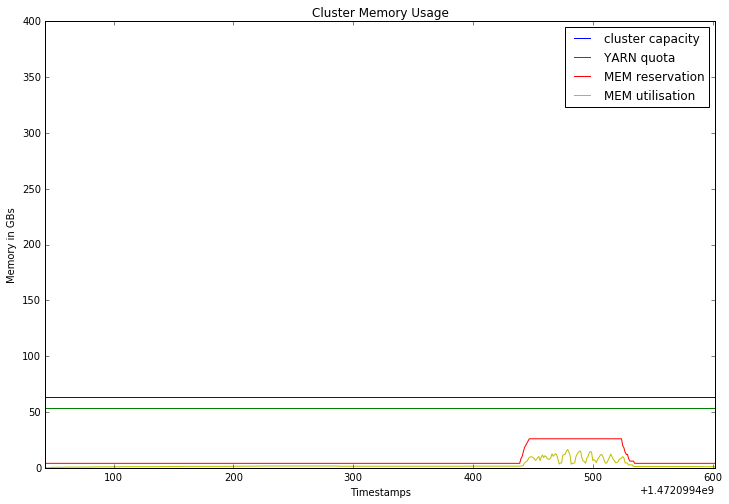

In [179]:
fig_cpu = plt.figure(figsize=(12,8))
ax_cpu = fig_cpu.add_subplot(111)
ax_cpu.plot(phy_CPU,'-b')
ax_cpu.plot(rsrv_CPU,'-g')
ax_cpu.plot(resv_cpu,'-r')
ax_cpu.plot(actl_cpu,'-y')
ax_cpu.axis([time[0],time[len(time)-1],0,160])
ax_cpu.set_ylabel('Number of cores')
ax_cpu.set_xlabel('Timestamps')
ax_cpu.set_title('Cluster CPU Usage')
ax_cpu.legend(['cluster capacity', 'YARN quota','CPU reservation','CPU utilisation'])

fig_mem = plt.figure(figsize=(12,8))
ax_mem = fig_mem.add_subplot(111)
ax_mem.plot(phy_mem,'-b')
ax_mem.plot(rsrv_mem,'-g')
ax_mem.plot(resv_mem,'-r')
ax_mem.plot(actl_mem,'-y')
ax_mem.axis([time[0],time[len(time)-1],0,400])
ax_mem.set_ylabel('Memory in GBs')
ax_mem.set_xlabel('Timestamps')
ax_mem.set_title('Cluster Memory Usage')
ax_mem.legend(['cluster capacity', 'YARN quota','MEM reservation','MEM utilisation'])

Percent: [##########] 100% Done...


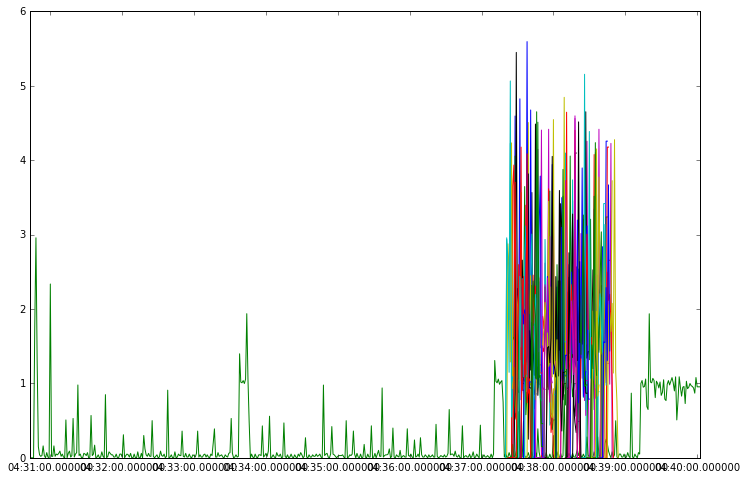

In [152]:
plt.figure(figsize=(12,8))
#AppDFFiltered = AppDFSorted[(AppDFSorted.node != 'null')]

index = 0
sum_cpu_resv = []
sum_cpu_used = []
effi_cpu_resv = []
container_lst = []
duration_lst = []
totalcons = len(AppDFFiltered.index)
for container in AppDFFiltered.index:
  cpu_used = get_cpu_actual_use(container,application_dataframe, app_cpu_profile)
  cpu_resv = AppDFFiltered.loc[container,"CPU"]
  duration = len(cpu_used)
  app = AppDFFiltered.loc[container,"app"]
  app_type = AppDFFiltered.loc[container,"type"]
  total_cpu_resv =cpu_resv*duration
  #calculate sum
  total = 0
  for i in cpu_used:
    total = total + i
  if total == 0: #no info on container used
    totalcons -= 1
    #print("Container $s does not info on memory usage" % container)
    continue
  sum_cpu_used.insert(index,total)
  sum_cpu_resv.insert(index,total_cpu_resv)
  effi_cpu_resv.insert(index,float(total)/total_cpu_resv)
  duration_lst.insert(index,duration)
  container_lst.insert(index,container)
  index += 1
  update_progress(float(index)/totalcons)
  plt.plot(cpu_used)

Percent: [##########] 100% Done...


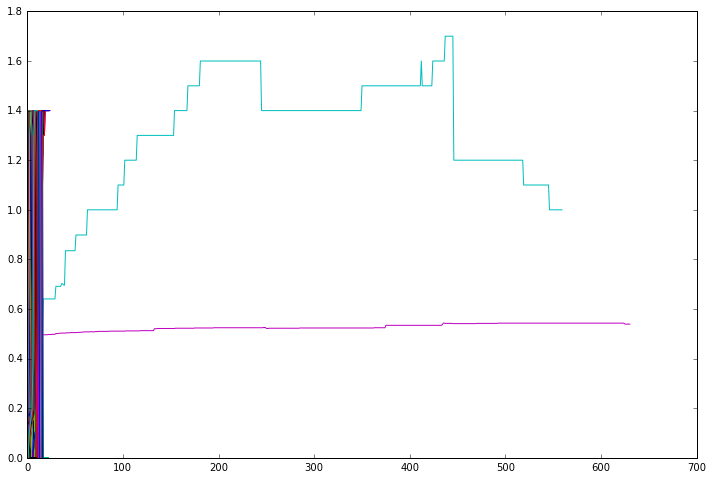

In [131]:
plt.figure(figsize=(12,8))
AppDFFiltered = AppDFSorted
index = 0
sum_mem_resv = []
sum_mem_used = []
effi_mem_resv = []
mem_container_lst = []
mem_duration_lst = []
mem_totalcons = len(AppDFFiltered.index)
for container in AppDFFiltered.index:
  mem_used = get_mem_actual_use(container,application_dataframe, app_mem_profile)
  mem_used = [ float(x) / (1024*1024*1024) for x in mem_used ]
  mem_resv = float(AppDFFiltered.loc[container,"mem"])/(1024*1024)
  duration = len(mem_used)
  app = AppDFFiltered.loc[container,"app"]
  app_type = AppDFFiltered.loc[container,"type"]
  user = AppDFFiltered.loc[container,"appowner"]
  total_mem_resv =mem_resv*duration
  #calculate sum
  total = 0
  for i in mem_used:
    total = total + i
  if total == 0: #no info on container used
    mem_totalcons -= 1
    #print("Container $s does not info on memory usage" % container)
    continue
  sum_mem_used.insert(index,total)
  sum_mem_resv.insert(index,total_mem_resv)
  effi_mem_resv.insert(index,float(total)/total_mem_resv)
  mem_duration_lst.insert(index,duration)
  mem_container_lst.insert(index,container)
  index += 1
  update_progress(float(index)/mem_totalcons)
  plt.plot(mem_used)

### Normalized with the allocation

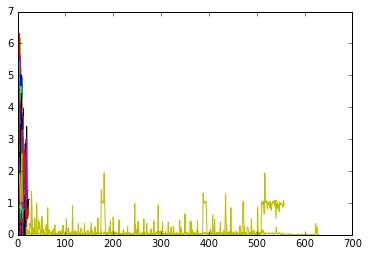

In [141]:
for container in AppDFSorted.index:
  cpu_usage = get_cpu_actual_use(container,application_dataframe, app_cpu_profile)
  cpu_usage = [ x /application_dataframe.loc[container,"CPU"] for x in cpu_usage ] # normalize with reserved CPU
  plt.plot(cpu_usage)

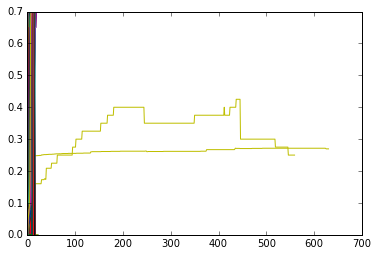

In [158]:
for container in AppDFSorted.index:
  mem_used = get_mem_actual_use(container,application_dataframe, app_mem_profile)
  mem_used = [ x / (application_dataframe.loc[container,"mem"]*1024) for x in mem_used ] # normalize with reserved mem
  plt.plot(mem_used)

In [ ]:
### One container view:
con_id = "bla bla bla"
con_filepath = AppIdPath + "/" + con_id + ".jsonprofile"

def loadcontainer( con_filepath ):
    #check if file exist:
    
    #read file
    with open(con_filepath, 'r') as fp:
        data = json.load(fp)
        container_name = data["container_id"]
        container_starttime = data["container_starttime"]       
        container_endtime = data["container_endtime"]
        """gather info for container"""
        container_type = data["application_info"]["appType"] #First task only
        appId = data["application_info"]["appId"]
        appname = data["application_info"]["appName"]
        appowner = data["application_info"]["appOwner"]
        if not data["nodeInfo"]:
            container_node = "null"
            container_node_mem_total = 0
            container_node_CPU_total = 0
            container_node_mem_rsrv = 0
            container_node_CPU_rsrv = 0
            container_mem_assigned = 0
            container_CPU_assigned = 0
        else:
            container_node = data["nodeInfo"]["id"]
            container_node_mem_total = data["nodeInfo"]["totalNodePhyMem"]
            container_node_CPU_total = data["nodeInfo"]["totalNodePhyCore"]
            container_node_mem_rsrv = data["nodeInfo"]["totalPmemAllocatedContainersMB"] * 1024
            container_node_CPU_rsrv = data["nodeInfo"]["totalVCoresAllocatedContainers"]
            container_mem_assigned = data["MemoryAssignedMB"] * 1024
            container_CPU_assigned = data["VCoresAssigned"]
        if not data["container_tasks"]:
            container_task = "null"
        else:
            container_task = data["container_tasks"][0]["task_type"]

                
        if not data["mem_usage"]:
        else:
            for record in data["mem_usage"]:
                
    return cpu_usage, mem_usage, cpu_resv, mem_resv, data

def get_cpuusage (data):
    tl = [] # timeline
    ccusage = [] # container cpu usage
    ccresv = data["VCoresAssigned"] #container cpu reserved
    nsi = [] # node_cpu_si
    nst = [] # node_cpu_st
    nsy = [] # node_cpu_sy
    nni = [] # node_cpu_ni
    nwa = [] # node_cpu_wa
    nid = [] # node_cpu_id
    nhi = [] # node_cpu_hi
    nus = [] # node_cpu_us
    ntcore = 0 # node_total_core
    ntquota = 0 # node_total_quota
    if data["nodeInfo"]:
        ntcore = data["nodeInfo"]["totalNodePhyCore"]
        ntquota = data["nodeInfo"]["totalVCoresAllocatedContainers"]
    if data["cpu_usage"]:
        i = 0
        for record in data["cpu_usage"]:
            tl.insert(i,record[i]["capture_time"])
            ccusage.insert(i,record[i]["container_load"])
            nsi.insert(i,record[i]["cpu_si"])
            nst.insert(i,record[i]["cpu_st"])
            nsy.insert(i,record[i]["cpu_sy"])
            nni.insert(i,record[i]["cpu_ni"])
            nwa.insert(i,record[i]["cpu_wa"])
            nid.insert(i,record[i]["cpu_id"])
            nhi.insert(i,record[i]["cpu_hi"])
            nus.insert(i,record[i]["cpu_us"])
            i += 1
    return tl, ccusage, ccresv, nsi, nst, nsy, nni, nwa, nid, nhi, nus, ntcore,ntquota

    def get_memusage(data):
    return 

fig_cpu = plt.figure(figsize=(12,8))
ax_cpu = fig_cpu.add_subplot(111)
ax_cpu.plot(phy_CPU,'-b')
ax_cpu.plot(rsrv_CPU,'-g')
ax_cpu.plot(resv_cpu,'-r')
ax_cpu.plot(actl_cpu,'-y')
ax_cpu.axis([time[0],time[len(time)-1],0,160])
ax_cpu.set_ylabel('Number of cores')
ax_cpu.set_xlabel('Timestamps')
ax_cpu.set_title('Cluster CPU Usage')
ax_cpu.legend(['cluster capacity', 'YARN quota','CPU reservation','CPU utilisation'])

fig_mem = plt.figure(figsize=(12,8))
ax_mem = fig_mem.add_subplot(111)
ax_mem.plot(phy_mem,'-b')
ax_mem.plot(rsrv_mem,'-g')
ax_mem.plot(resv_mem,'-r')
ax_mem.plot(actl_mem,'-y')
ax_mem.axis([time[0],time[len(time)-1],0,400])
ax_mem.set_ylabel('Memory in GBs')
ax_mem.set_xlabel('Timestamps')
ax_mem.set_title('Cluster Memory Usage')
ax_mem.legend(['cluster capacity', 'YARN quota','MEM reservation','MEM utilisation'])

In [28]:
# Display resource usage of all containers of one application seperated on each node

In [ ]:
# Should depend on the job type to display